In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.plot([0,1], [0,1])
plt.show()
clear_output()

In [45]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from utils.helper import set_seed
from matplotlib import pyplot as plt
from utils.xray_plot import draw_pred
import os
import re
import random
from matplotlib import pyplot as plt
import json
import cv2
#import skimage
import numpy as np
from collections import OrderedDict
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
import torch

In [46]:
transform_pipeline =  transforms.Compose([
     lambda x: x/255,
                               transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ])

In [47]:
##? 
class XrayPretrained(nn.Module):
    def __init__(self):
        super(XrayPretrained, self).__init__()
        self.resnet = pretrained_model # output size = resnet18_shape
        self.fc1=nn.Linear(resnet34_shape,  output_size)

    def forward(self, x):
        x = self.resnet(x)
        x = nn.functional.relu(x)
        x = self.fc1(x)
        return x
model = torch.load("resnet34-600ep-adam")


In [48]:
# mean=[0.485, 0.456, 0.406],
#                                     std=[0.229, 0.224, 0.225])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                lambda x: x*255
                               ])



In [12]:
# run inference on unlabeled images
test_dir = "data_unann_padded"
test_images = os.listdir(test_dir)[:20]

In [15]:
def extract_img(img_name):
    sample_image = os.path.join(test_dir, img_name)
    print(sample_image)
    img = cv2.imread(sample_image)
    if img is None:
        print("Error: Image not loaded. Check the file path.")
    resized_img = cv2.resize(img, (256,256))
    img = torch.from_numpy(resized_img).permute(2, 1, 0)
    img = transform_pipeline(img)
    return img
unlabeled_x = torch.stack( [extract_img(n) for n in test_images]) 

data_unann_padded\1014.postopAxillary.jpg
data_unann_padded\1014.preopAxillary.jpg
data_unann_padded\1023_axillary postop.png
data_unann_padded\1027_axillary post op.png
data_unann_padded\1027_axillary pre op.png
data_unann_padded\1031_ax post op.png
data_unann_padded\1031_ax pre op.png
data_unann_padded\1034_ax post op.png
data_unann_padded\1036.postopAxillary.jpg
data_unann_padded\1036.preopAxillary.jpg
data_unann_padded\1037.2ndpostopAxillary.jpg
data_unann_padded\1037.postopAxillary.jpg
data_unann_padded\1037.preopAxillary.jpg
data_unann_padded\1046.postopAxillary.jpg
data_unann_padded\1046.preopAxillary.jpg
data_unann_padded\1048.preopAx.jpg
data_unann_padded\1049_ax post op.png
data_unann_padded\1049_ax pre op.png
data_unann_padded\1050_ax pre op.png
data_unann_padded\1051.postopAxillary.jpg


In [16]:
unlabeled_x.shape

torch.Size([20, 3, 256, 256])

In [52]:
unlabeled_x = extract_img("LC828.png").unsqueeze(0)

data_unann_padded\LC828.png


In [53]:
model.eval()

with torch.no_grad():
  # Get the predictions from the model
    outputs = model(unlabeled_x)


In [54]:
inv_unlabeled_x = invTrans(unlabeled_x)

In [55]:
idx = 0

tensor([157.5560, 124.1798,  39.4827, 171.0892, 180.6405])


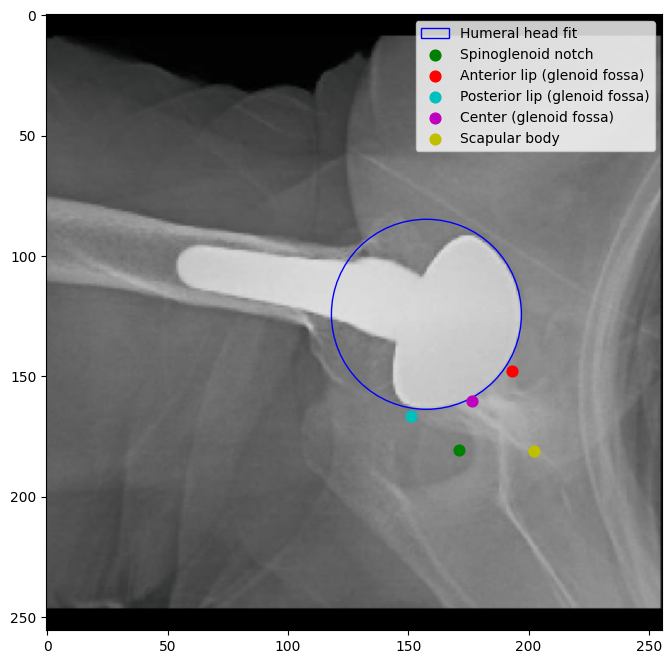

In [56]:
plt.figure(figsize=(20, 8))
draw_pred(inv_unlabeled_x, outputs, idx)


In [57]:
import matplotlib.patches as patches
from PIL import Image
import io

ordered_labels = ['Humeral head fit',
 'Spinoglenoid notch',
 'Anterior lip (glenoid fossa)',
 'Posterior lip (glenoid fossa)',
 'Center (glenoid fossa)',
 'Scapular body']

def draw_pred_tr(y, num_ell=2, num_pts=4) -> None:
    
    colors = iter(['b','lime','r','c','m','y'])
    labels = iter(ordered_labels)

    # the first 5 used to be ellipse
    ellipses = y[:5]
    points = y[5:]
    # torch auto casts data to floating point numbers
    # to make the behavior of plt.imshow consistent
    # recast the image to int type
    for i in range(num_ell):
        if i == 0: # 'Circle fit to humeral articular surface'
            cx, cy, rx= ellipses[0:3]
            ry = rx
            dx, dy = rx * 2, ry * 2
            plt.gca().add_patch(
            patches.Ellipse(xy=(cx, cy), width=dx, height=dy,fill=False,color=next(colors),label = next(labels)))

        if i == 1: # 'Spinoglenoid notch'
            x, y = ellipses[3:5]
            plt.scatter(x,y,color=next(colors),label = next(labels), s=60, linewidths=0.5)
    

    for k in range(num_pts):
        x, y = points[2*k:2*(k+1)]
        plt.scatter(x,y,color=next(colors),label = next(labels), s=60, linewidths=0.5)



def draw_pred_(y, num_ell=2, num_pts=4) -> None:
    
    colors = iter(['b','lime','r','c','m','y'])
    labels = iter(ordered_labels)

    # the first 5 used to be ellipse
    ellipses = y[:5]
    points = y[5:]
    # torch auto casts data to floating point numbers
    # to make the behavior of plt.imshow consistent
    # recast the image to int type
    for i in range(num_ell):
        if i == 0: # 'Circle fit to humeral articular surface'
            cx, cy, rx= ellipses[0:3]
            ry = rx
            dx, dy = rx * 2, ry * 2
            plt.gca().add_patch(
            patches.Ellipse(xy=(cx, cy), width=dx, height=dy,fill=False,color=next(colors),label = next(labels) + ": inferred", linestyle="--"))

        if i == 1: # 'Spinoglenoid notch'
            x, y = ellipses[3:5]
            plt.scatter(x,y,color=next(colors),label = next(labels) + ": inferred", s=60, marker="X", linewidths=0.5)
    

    for k in range(num_pts):
        x, y = points[2*k:2*(k+1)]
        plt.scatter(x,y,color=next(colors),label = next(labels) +": inferred", s=60, marker="X", linewidths=0.5)

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


ordered_labels = ['Humeral head fit',
 'Spinoglenoid notch',
 'Anterior lip (glenoid fossa)',
 'Posterior lip (glenoid fossa)',
 'Center (glenoid fossa)',
 'Scapular body']

# "LC828.png"
tr = torch.Tensor([537.92, 393.95, 132, 584.61, 581.63, 657.76,469.97,518.58,533.76,603.63,514.43,689.80,585.30])

# PM913-2.png

tr_pm913 =  torch.Tensor([316.42, 276.47, 127, 393.21, 476.72, 459.64, 326.98,335.81,415.91,406.74,382.70, 471.4, 497.8])

# 1014.postopAxillary.jpg

tr_1014pa = torch.Tensor([309.79, 365.78, 144.1, 264.88, 584.89, 181.1, 436.60, 357.5,556.2,255.7,503.7, 169.2,634.7])

In [58]:
def calc_eud(pred, tr):
    diff = pred - tr

    hum = np.sqrt(diff[0]** 2+ diff[1]**2)
    hum_r = np.abs(diff[2])

    notch  = np.sqrt(diff[3]** 2+ diff[4]**2)

    alip = np.sqrt(diff[5]** 2+ diff[6]**2)

    plip = np.sqrt(diff[7]** 2+ diff[8]**2)

    clip =np.sqrt(diff[9]** 2+ diff[10]**2)

    sc =np.sqrt(diff[11]** 2+ diff[12]**2)

    return list(map(lambda x: np.round(x.item(),4), [hum, hum_r, notch, alip, plip, clip, sc ]))

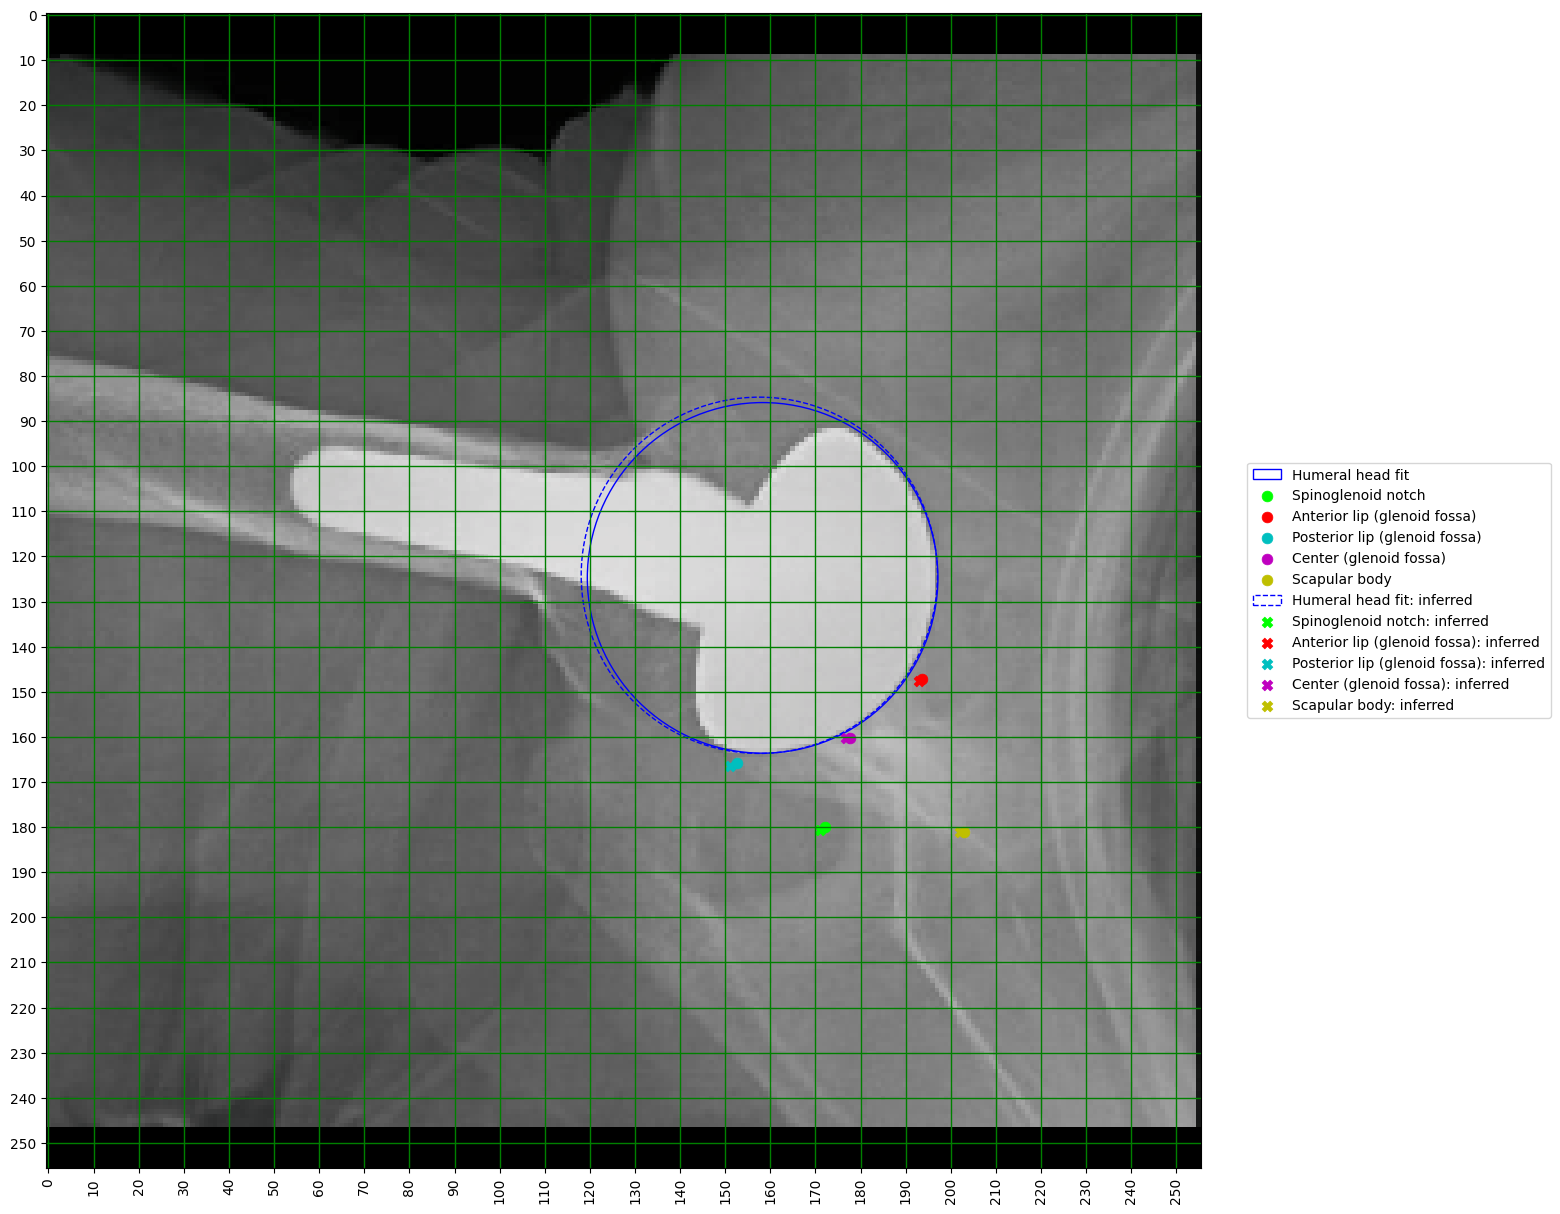

In [59]:

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize = (15, 15))


plt.imshow(inv_unlabeled_x[0, :, :, :].permute(2, 1, 0).int())
draw_pred_tr([158.2845, 124.7485,  38.8531, 172.0232, 179.9739, 193.5478, 147.1176,
        152.5937, 165.8880, 177.6199, 160.2001, 202.9756, 181.0538])
draw_pred_(outputs[0])


# Display the image

# Define grid parameters
grid_color = 'green'
pixel_interval = 10  # Interval between grid lines (adjust as needed)

# Add grid lines
ax.xaxis.set_major_locator(ticker.MultipleLocator(pixel_interval))
ax.yaxis.set_major_locator(ticker.MultipleLocator(pixel_interval))
ax.grid(which='major', color=grid_color, linestyle='-', linewidth=1)
plt.xticks(rotation = 90);

In [60]:
diff = outputs[0] - torch.Tensor([158.2845, 124.7485,  38.8531, 172.0232, 179.9739, 193.5478, 147.1176,
        152.5937, 165.8880, 177.6199, 160.2001, 202.9756, 181.0538])
diff

tensor([-0.7285, -0.5687,  0.6296, -0.9340,  0.6665, -0.5670,  0.4275, -1.5770,
         0.5475, -0.9299, -0.0479, -0.8607,  0.1221])

In [61]:
(diff**2).mean()

tensor(0.5754)

In [62]:
calc_eud(outputs[0],good)

[0.9242, 0.6296, 1.1474, 0.7101, 1.6694, 0.9311, 0.8693]

In [42]:
good = torch.Tensor([158.2845, 124.7485,  38.8531, 172.0232, 179.9739, 193.5478, 147.1176,
        152.5937, 165.8880, 177.6199, 160.2001, 202.9756, 181.0538])

In [64]:
# auxilliary lines

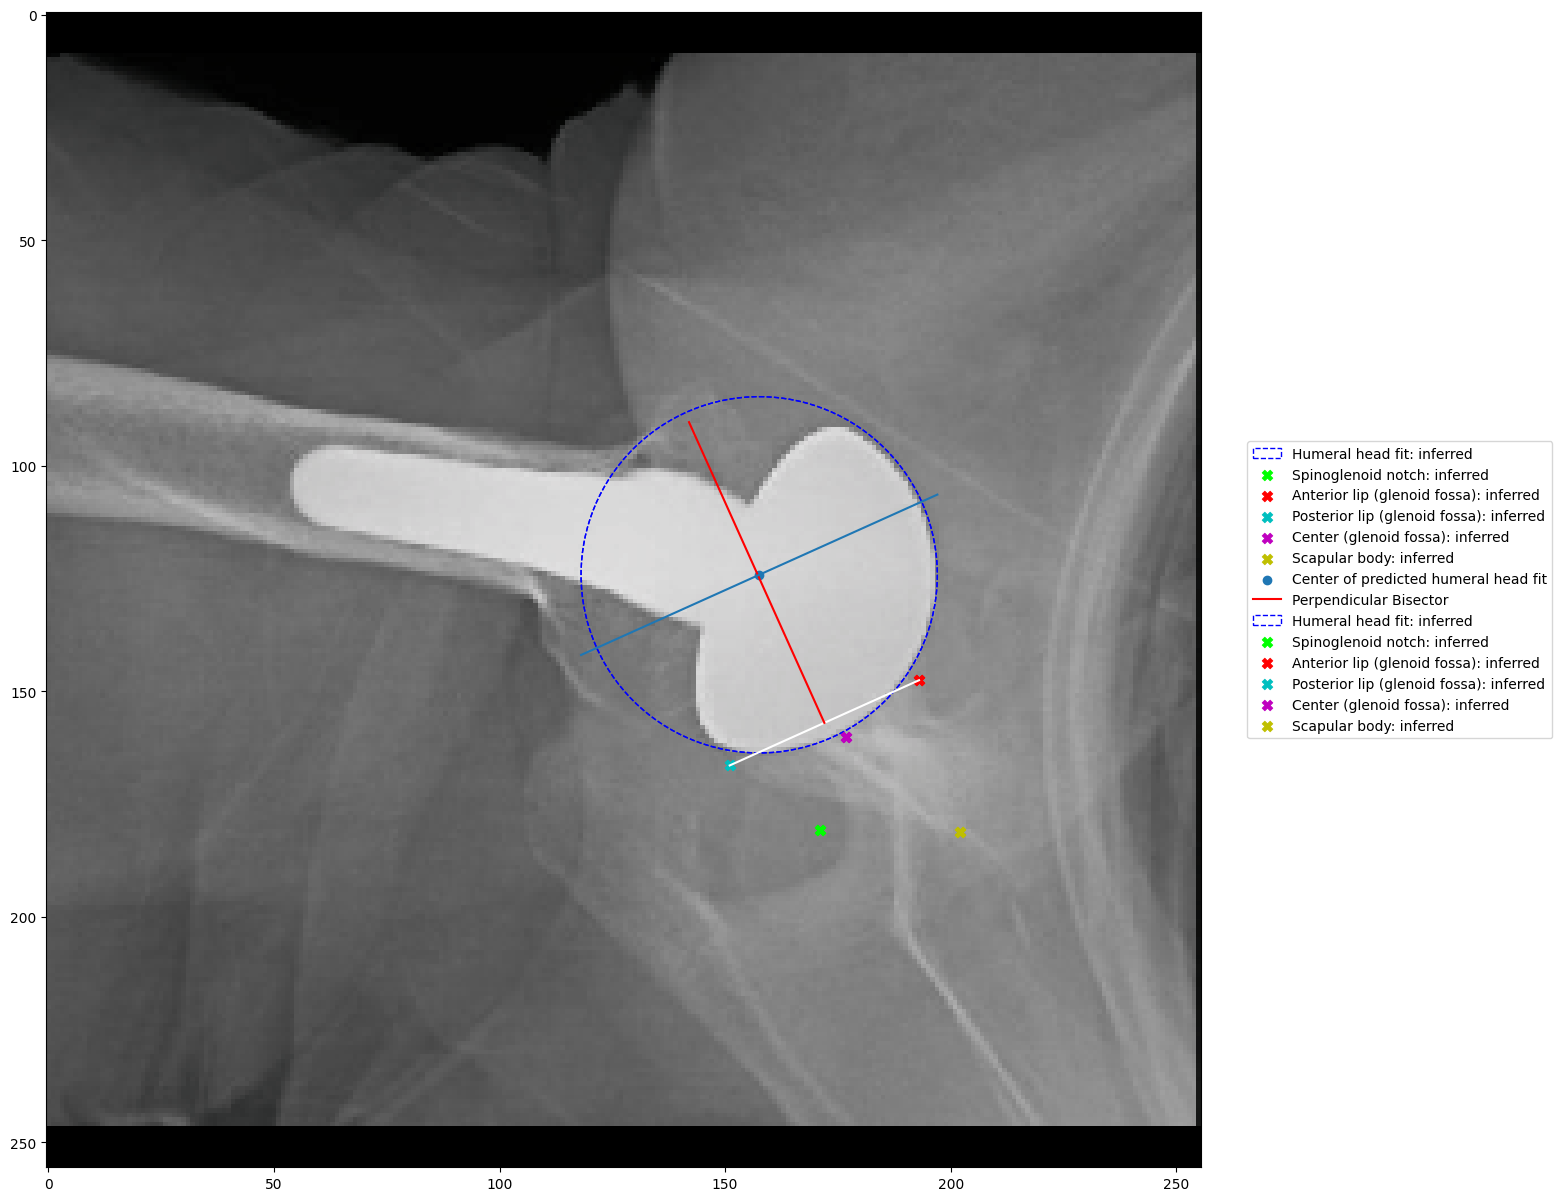

: 

In [96]:

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize = (15, 15))


plt.imshow(inv_unlabeled_x[0, :, :, :].permute(2, 1, 0).int())
draw_pred_(outputs[0])


# Display the image

# Define grid parameters
grid_color = 'green'
pixel_interval = 10  # Interval between grid lines (adjust as needed)

# Add grid lines
# ax.xaxis.set_major_locator(ticker.MultipleLocator(pixel_interval))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(pixel_interval))
# ax.grid(which='major', color=grid_color, linestyle='-', linewidth=1)
# plt.xticks(rotation = 90);

plt.scatter(outputs[0][0], outputs[0][1], label="Center of predicted humeral head fit")

plt.plot(np.linspace(outputs[0][7],outputs[0][5],100 ), np.linspace(outputs[0][8],outputs[0][6],100 ), c="white" );

x1, y1 = outputs[0][7], outputs[0][8]
x2, y2 = outputs[0][5], outputs[0][6]

# Calculate the midpoint of the line segment
midpoint_x = (x1 + x2) / 2
midpoint_y = (y1 + y2) / 2

slope = (y2 - y1) / (x2 - x1)
perpendicular_slope = -1 / slope  # Negative reciprocal
displacement = -30  # Adjust this value as needed

# Calculate the new point on the perpendicular bisector
new_x = midpoint_x + displacement
new_y = midpoint_y + perpendicular_slope * displacement

plt.plot([midpoint_x, new_x], [midpoint_y, new_y], c="red", label="Perpendicular Bisector")




new_x = midpoint_x + displacement
new_y = midpoint_y + perpendicular_slope * displacement

displacement = outputs[0][2]

plt.plot([outputs[0][0]-displacement, outputs[0][0]+displacement], 
         [outputs[0][1] -slope *displacement , outputs[0][1] +slope * displacement ])


draw_pred_(outputs[0])


In [86]:
np.arange(outputs[0][9],outputs[0][7],100 )

array([], dtype=float64)

In [80]:
np.arange(outputs[0][7],outputs[0][5],100 )

array([151.0166626])